## Part A Functions to Run Before training/Results

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install pytorch_lightning &> /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
from sklearn import metrics
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.axes3d import Axes
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
from inspect import modulesbyfile
from torchvision.models.detection.image_list import ImageList

import h5py
import albumentations as A
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
torch.set_printoptions(linewidth=100)

np.set_printoptions(linewidth=100)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# seed = 17
# torch.manual_seed(seed);
!gdown 1YuFkOkeZ_3iaf71W1QfaZqqO9nZq_QUy
!gdown 1PDctbNuLSpxVU6MA-Qy6Unf_Q-bQf0jd
!gdown 1_fR9WLy10WRzlZQBaMv8BFkT4f_4xr99
!gdown 1oSiBPjyxMOaC496rLVQA-xG-fgK1ulcA
!gdown 1h6VQWmbq41cJ9O1WdRalc8iOsox2HCeO # pretrained backbone

Downloading...
From: https://drive.google.com/uc?id=1YuFkOkeZ_3iaf71W1QfaZqqO9nZq_QUy
To: /content/hw3_mycocodata_mask_comp_zlib.h5
100% 4.30M/4.30M [00:00<00:00, 198MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PDctbNuLSpxVU6MA-Qy6Unf_Q-bQf0jd
To: /content/hw3_mycocodata_labels_comp_zlib.npy
100% 269k/269k [00:00<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_fR9WLy10WRzlZQBaMv8BFkT4f_4xr99
To: /content/hw3_mycocodata_img_comp_zlib.h5
100% 801M/801M [00:02<00:00, 283MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oSiBPjyxMOaC496rLVQA-xG-fgK1ulcA
To: /content/hw3_mycocodata_bboxes_comp_zlib.npy
100% 327k/327k [00:00<00:00, 129MB/s]
Downloading...
From: https://drive.google.com/uc?id=1h6VQWmbq41cJ9O1WdRalc8iOsox2HCeO
To: /content/checkpoint680.pth
100% 110M/110M [00:00<00:00, 186MB/s]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def load_datset(viz):
  labels_og = np.load("hw3_mycocodata_labels_comp_zlib.npy", allow_pickle=True, encoding='latin1')
  bbox_og = np.load("hw3_mycocodata_bboxes_comp_zlib.npy", allow_pickle=True, encoding='latin1')
  imgs = h5_to_npy("hw3_mycocodata_img_comp_zlib.h5") 
  masks_og = h5_to_npy("hw3_mycocodata_mask_comp_zlib.h5")

  # Testing if Files have been sucessfully loaded
  if viz:
    c=['none', 'green', 'blue','yellow']
    counter = []
    for l in labels_og:
      counter.append(len(l))
    for i in range(5):
      img_o=np.transpose(imgs[i], axes=(1,2,0))
      plt.imshow(img_o)
      maskstart= int(np.sum(counter[:i]))
      for num in range(maskstart, maskstart+len(labels_og[i]),1):
        plt.imshow(masks_og[num], cmap=ListedColormap([c[0], c[labels_og[i][num-maskstart]]]), alpha=.3)
        xl, yl, xr, yr = bbox_og[i][num-maskstart]
        plt.gca().add_patch(Rectangle((xl,yl),(xr-xl),(yr-yl),linewidth=1,edgecolor='r',facecolor='none'))
      plt.show()
  return labels_og, bbox_og, imgs, masks_og

def vizualise_dataloader(images, labels, bbox, masks):
  c=['none', 'green', 'blue','red']
  cc=['none', 'g', 'b','r']
  cl=['none', 'Vehicle', 'Person','Animal']
  for i in range(len(images)):
    img, label, bbox_, mask_ = images[i], labels[i], bbox[i], masks[i]
    img=img.numpy()
    x_min = img.min(axis=(1, 2), keepdims=True)
    x_max = img.max(axis=(1, 2), keepdims=True)
    img = (img - x_min)/(x_max-x_min)
    plt.imshow(np.transpose(img, axes=(1,2,0)))
    for j in range(len(bbox_)):
      plt.imshow(np.squeeze(mask_[j].numpy()), cmap=ListedColormap(['none', c[label[j]]]), alpha=.3)
      xl, yl, xr, yr = bbox_[j].numpy()
      plt.gca().add_patch(Rectangle((xl,yl),(xr-xl),(yr-yl),linewidth=1,edgecolor=cc[label[j]],facecolor='none'))
      plt.text(xl+0.25, yl+0.25, cl[label[j]], color='y')

    plt.show()

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, bbox, masks):
        self.x_scale = ( 800 / 300)
        self.y_scale = ( 1066 / 400)
        self.imgs_data = data
        self.labels_data = labels
        self.bbox_data = bbox
        self.mask_data = []

        counter = []
        for l in labels:
          counter.append(len(l))
        for i in range(len(data)):
          maskstart= int(np.sum(counter[:i]))
          temp=[]
          for num in range(maskstart, maskstart+len(labels[i]),1):
            temp.append(masks[num])
          self.mask_data.append(temp)

        self.transform=transforms.Compose([transforms.Resize((800,1066)), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), transforms.Pad((11,0))])
        self.transform_mask=transforms.Compose([transforms.Resize((800,1066)), transforms.Pad((11,0))])

    def __getitem__(self, index):
        image = self.transform(torch.from_numpy(self.imgs_data[index,:,:,:].astype(float)/255))
        old_mask=self.mask_data[index]

        masks=[]
        for i in range(len(old_mask)):
          masks.append(self.transform_mask(torch.from_numpy((old_mask[i].reshape(1,300,400)).astype(float))))

        label=self.labels_data[index]
        bbox=np.zeros(self.bbox_data[index].shape)
        bbox[:,0]= self.bbox_data[index][:,0]*self.x_scale + 11
        bbox[:,2]= self.bbox_data[index][:,2]*self.x_scale + 11
        bbox[:,1]= self.bbox_data[index][:,1]*self.y_scale
        bbox[:,3]= self.bbox_data[index][:,3]*self.y_scale
        bbox= torch.from_numpy(bbox)
        label= torch.from_numpy(label)
        return image, label, bbox, masks, index
        
    def __len__(self):
        return len(self.imgs_data)
    
    def collate_fn(self,batch):
        images, labels, bounding_boxes, masks, indexs = list(zip(*batch))
        return torch.stack(images), labels, bounding_boxes, masks, indexs

def h5_to_npy(loc):
  file= h5py.File(loc,'r') 
  key = list(file.keys())[0]
  # data = list(file[key])
  data= file[key][()]
  return data


def MultiApply(func, *args, **kwargs):
    pfunc = partial(func, **kwargs) if kwargs else func
    map_results = map(pfunc, *args)
  
    return tuple(map(list, zip(*map_results)))

# This function compute the IOU between two set of boxes 
def IOU(tar1, tar2):
    ##################################
    #TODO compute the IOU between the boxA, boxB boxes
    ##################################
    xl_int = torch.maximum(tar1[0], tar2[0])
    yl_int = torch.maximum(tar1[1], tar2[1])
    xr_int = torch.minimum(tar1[2], tar2[2])
    yr_int = torch.minimum(tar1[3], tar2[3])
    Area_of_int = torch.maximum(torch.Tensor([0]).to(device), xr_int - xl_int) * torch.maximum(torch.Tensor([0]).to(device), yr_int - yl_int)
    Area_of_union = (torch.abs(tar1[2] - tar1[0]) * torch.abs(tar1[3] - tar1[1])) + (torch.abs(tar2[2] - tar2[0]) * torch.abs(tar2[3] - tar2[1])) - Area_of_int
    return Area_of_int/(Area_of_union+1e-6)

def IOU_all(tar1, tar2):
    ##################################
    #TODO compute the IOU between the boxA, boxB boxes
    ##################################
    xl_int = torch.maximum(tar1[:,0], tar2[0])
    yl_int = torch.maximum(tar1[:,1], tar2[1])
    xr_int = torch.minimum(tar1[:,2], tar2[2])
    yr_int = torch.minimum(tar1[:,3], tar2[3])
    Area_of_int = torch.maximum(torch.Tensor([0]).to(device), xr_int - xl_int) * torch.maximum(torch.Tensor([0]).to(device), yr_int - yl_int)
    Area_of_union = (torch.abs(tar1[:,2] - tar1[:,0]) * torch.abs(tar1[:,3] - tar1[:,1])) + (torch.abs(tar2[2] - tar2[0]) * torch.abs(tar2[3] - tar2[1])) - Area_of_int
    return Area_of_int/(Area_of_union+1e-6)


# This function decodes the output of the box head that are given in the [t_x,t_y,t_w,t_h] format
# into box coordinates where it return the upper left and lower right corner of the bbox
# Input:
#       regressed_boxes_t: (total_proposals,4) ([t_x,t_y,t_w,t_h] format)
#       flatten_proposals: (total_proposals,4) ([x1,y1,x2,y2] format)
# Output:
#       box: (total_proposals,4) ([x1,y1,x2,y2] format)
def output_decodingd(regressed_boxes_t,flatten_proposals, labels, device='cpu'):
  #######################################
  # TODO decode the output
  #######################################
  flatten_proposals = xyxy_xywh(flatten_proposals, to_wh=True)
  xa = flatten_proposals[:,0]
  ya = flatten_proposals[:,1]
  wa = flatten_proposals[:,2]
  ha = flatten_proposals[:,3]

  newcoords = torch.zeros(regressed_boxes_t.shape)
  tx  = regressed_boxes_t[:,0]
  ty  = regressed_boxes_t[:,1]
  tw  = regressed_boxes_t[:,2]
  th  = regressed_boxes_t[:,3]

  # Decoding
  cx = wa*tx + xa
  cy = ha*ty + ya
  w = wa* torch.exp(tw)
  h = ha* torch.exp(th)

  newcoords[:,0] = cx - w/2
  newcoords[:,1] = cy - h/2
  newcoords[:,2] = cx + w/2 
  newcoords[:,3] = cy + h/2

  newcoords[(labels==0)[:,0],:] = 0
  return newcoords

In [33]:
def output_decoding(flatten_out,flatten_anchors, device='cpu'):
    xa = flatten_anchors[:,0]
    ya = flatten_anchors[:,1]
    wa = flatten_anchors[:,2]
    ha = flatten_anchors[:,3]

    newcoords = torch.zeros(flatten_out.shape)
    tx  = flatten_out[:,0]
    ty  = flatten_out[:,1]
    tw  = flatten_out[:,2]
    th  = flatten_out[:,3]

    # Decoding
    cx = wa*tx + xa
    cy = ha*ty + ya
    w = wa* torch.exp(tw)
    h = ha* torch.exp(th)

    newcoords[:,0] = cx - w/2
    newcoords[:,1] = cy - h/2
    newcoords[:,2] = cx + w/2 
    newcoords[:,3] = cy + h/2
    return newcoords

def output_flattening(out_r, out_c, anchors):
    bz = len(out_r[0])
    flatten_regr = []
    flatten_clas = []
    flatten_anchors = []
    for lev in range(len(out_r)):
      out_rl = torch.permute(out_r[lev],(0,2,3,1))
      out_cl = torch.permute(out_c[lev],(0,2,3,1))
      anchorl = torch.permute(anchors[lev], (1, 2, 0, 3)).reshape(out_rl.shape[1], out_rl.shape[2],12)
      anchorl =  anchorl.repeat(bz,1,1,1)

      
      flat_clasl = out_cl.reshape(-1,3)
      flat_regl = out_rl.reshape(-1, 12)
      flat_ancl = anchorl.reshape(-1,12)

      for an in range(0,12,4):
        flatten_regr.append(flat_regl[:, an:an+4])
        flatten_anchors.append(flat_ancl[:, an:an+4])
        flatten_clas.append(flat_clasl[:, an//4])
      
    flatten_regr = torch.concat(flatten_regr, 0)
    flatten_clas = torch.concat(flatten_clas, 0)
    flatten_anchors = torch.concat(flatten_anchors, 0)
    return flatten_regr, flatten_clas, flatten_anchors

In [86]:
class RPNHead(pl.LightningModule):
    def __init__(self, num_anchors=3, in_channels=256,
                 anchors_param=dict(ratio=[[1, 0.5, 2], [1, 0.5, 2], [1, 0.5, 2], [1, 0.5, 2], [1, 0.5, 2]],
                                    scale=[32, 64, 128, 256, 512],
                                    grid_size=[(200, 272), (100, 136), (50, 68), (25, 34), (13, 17)],
                                    stride=[4, 8, 16, 32, 64])):
        super(RPNHead,self).__init__()
        ######################################
        # TODO initialize RPN
        #######################################
        self.loss_sum=0
        self.closs_sum=0
        self.rloss_sum=0
        self.epoch_loss=[]
        self.val_epoch_loss=[]
        self.epoch_closs=[]
        self.val_epoch_closs=[]
        self.epoch_rloss=[]
        self.val_epoch_rloss=[]
        self.lr =  0.01

        self.bceloss = nn.BCELoss(reduction ='sum')
        self.smoothl1 = nn.SmoothL1Loss(reduction ='sum')
          
        # TODO  Define Intermediate Layer
        self.intermediate_layer =  nn.Sequential(
            # Convolution 1
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=1, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),   
        )

        # TODO  Define Proposal Classifier Head
        self.classhead= nn.Sequential(nn.Conv2d(256, 3, kernel_size=(1,1), stride=1, padding='same'),  nn.Sigmoid())

        # TODO Define Proposal Regressor Head
        self.reghead= nn.Sequential(nn.Conv2d(256, 12, kernel_size=(1,1), stride=1, padding='same'),  nn.Sigmoid())
    
        #  find anchors
        self.anchors_param=anchors_param
        self.anchors=self.create_anchors(self.anchors_param['ratio'],self.anchors_param['scale'],self.anchors_param['grid_size'],self.anchors_param['stride'])
        self.ground_dict= {}
        self.backbone = Resnet50Backbone()
        
    # Forward each level of the FPN output through the intermediate layer and the RPN heads
    # Input:
    #       X: list:len(FPN){(bz,256,grid_size[0],grid_size[1])}
    # Ouput:
    #       logits: list:len(FPN){(bz,1*num_anchors,grid_size[0],grid_size[1])}
    #       bbox_regs: list:len(FPN){(bz,4*num_anchors, grid_size[0],grid_size[1])}
    def forward(self, images):
        feature_pyramid = [v.detach() for v in self.backbone(images).values()] # this has strides [4,8,16,32,64]
        logits=[]
        bbox_regs=[]
        for i in range(len(feature_pyramid)):
          pyram= feature_pyramid[i]
          intermediate= self.intermediate_layer(pyram)

          class_out= self.classhead(intermediate)
          reg_out= self.reghead(intermediate)

          logits.append(class_out)
          bbox_regs.append(reg_out)
        return logits, bbox_regs

    # This function creates the anchor boxes for all FPN level
    # Input:
    #       aspect_ratio: list:len(FPN){list:len(number_of_aspect_ratios)}
    #       scale:        list:len(FPN)
    #       grid_size:    list:len(FPN){tuple:len(2)}
    #       stride:        list:len(FPN)
    # Output:
    #       anchors_list: list:len(FPN){(grid_size[0]*grid_size[1]*num_anchors,4)}
    def create_anchors(self, aspect_ratio, scale, grid_size, stride):
        anchors_list = []
        for lev in range(len(scale)):
          anchors_list.append(self.create_anchors_single(aspect_ratio[lev], scale[lev], grid_size[lev], stride[lev]))
        return anchors_list

    # This function creates the anchor boxes for one FPN level
    # Input:
    #      aspect_ratio: list:len(number_of_aspect_ratios)
    #      scale: scalar
    #      grid_size: tuple:len(2)
    #      stride: scalar
    # Output:
    #       anchors: (grid_size[0]*grid_size[1]*num_acnhors,4)
    def create_anchors_single(self, aspect_ratio, scale, grid_sizes, stride):
        ######################################
        # TODO create anchors
        ######################################
        anchors=[]
        for aspec in aspect_ratio:
          h= scale/(aspec**0.5)
          w= aspec * h
          # print(h,w, aspec, grid_sizes)
          wst = torch.ones((grid_sizes[0], grid_sizes[1])) * w
          hst = torch.ones((grid_sizes[0], grid_sizes[1])) * h

          xs = torch.linspace(0, grid_sizes[0]-1, steps=grid_sizes[0])
          ys = torch.linspace(0, grid_sizes[1]-1, steps=grid_sizes[1])
          x_, y_ = torch.meshgrid(ys, xs, indexing='xy') 
          x = x_ * stride
          y = y_ * stride
          cx =  x+8
          cy =  y+8

          single_anchors = torch.stack((cx, cy, wst, hst))
          single_anchors = torch.permute(single_anchors, (1, 2, 0))
          assert single_anchors.shape == (grid_sizes[0] , grid_sizes[1],4)

          anchors.append(single_anchors)

        anchors = torch.stack((anchors))   #.reshape(grid_sizes[0]*grid_sizes[1]*len(aspect_ratio),4)
        assert anchors.shape == (len(aspect_ratio),grid_sizes[0], grid_sizes[1],4)

        return anchors.to(device)  

    def get_anchors(self):
        return self.anchors

    # Post process the output for one image
    # Input:
    #      mat_clas: (1,grid_size[0],grid_size[1])}  (scores of the output boxes)
    #      mat_coord: (4,grid_size[0],grid_size[1])} (encoded coordinates of the output boxes)
    # Output:
    #       nms_clas: (Post_NMS_boxes)
    #       nms_prebox: (Post_NMS_boxes,4) (decoded coordinates of the boxes that the NMS kept)
    def postprocessImg(self,mat_clas,mat_coord, IOU_thresh,keep_num_preNMS, keep_num_postNMS):
      ######################################
      # TODO postprocess a single image
      #####################################
      keep_num_preNMS = 2000
      # nms_prebox = 1
      flatten_bbox,flatten_clas,flatten_anchors=output_flattening(mat_coord,mat_clas,self.get_anchors()) 
      decoded_coord=output_decoding(flatten_bbox,flatten_anchors).to(device)

      # top k boxes - sort thres_clas,  keep top k
      sorted_score, sorted_idx = torch.sort(flatten_clas, descending = True)
      sorted_idx = sorted_idx[:keep_num_preNMS].to(device)
      topK_score = sorted_score[sorted_idx]
      topK_bbox = decoded_coord[sorted_idx]
      
      # nms_clas, nms_prebox = self.non_max_suppression(topK_bbox, topK_score)
      scores = MatrixNMS(topK_bbox.to(device), topK_score.to(device))
      top_scores, top5kidx = torch.sort(scores, descending=True)
      top_scores =top_scores[0 : keep_num_postNMS]
      topboxes = topK_bbox[0 : keep_num_postNMS]
      return top_scores, topboxes

In [8]:
def Resnet50Backbone(checkpoint_file=None, device="cuda", eval=True):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)

    if eval == True:
        model.eval()

    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    resnet50_fpn = model.backbone

    if checkpoint_file:
        checkpoint = torch.load(checkpoint_file)

        resnet50_fpn.load_state_dict(checkpoint['backbone'])

    return resnet50_fpn

In [22]:
def pretrained_models_680(checkpoint_file,eval=True, useours=True):
  if useours:
    backbone = Resnet50Backbone().to(device)
    rpn = RPNHead.load_from_checkpoint(checkpoint_path=checkpoint_file).to(device)
    if(eval):
      backbone.eval()
      rpn.eval()

  else:
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    if(eval):
        model.eval()
    model = model.to(device)
    backbone = model.backbone
    rpn = model.rpn

    if(eval):
        backbone.eval()
        rpn.eval()

    rpn.nms_thresh=0.6
    checkpoint = torch.load(checkpoint_file)

    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])

  return backbone, rpn

In [10]:
def xyxy_xywh(coords, to_wh=False):
  if to_wh:
    if coords.shape[:]==torch.Size([4]):
      coords =  coords.reshape(1,4)
    newcoords = torch.zeros(coords.shape).to(device)
    xl  = coords[:,0]
    yl  = coords[:,1]
    xr  = coords[:,2]
    yr  = coords[:,3]

    newcoords[:,2] = xr - xl
    newcoords[:,3] = yr - yl
    newcoords[:,0] = xl + newcoords[:,2]/2
    newcoords[:,1] = yl + newcoords[:,3]/2
    return newcoords

  else:
    newcoords = torch.zeros(coords.shape).to(device)
    cx  = coords[:,0]
    cy  = coords[:,1]
    w  = coords[:,2]
    h  = coords[:,3]

    newcoords[:,0] = cx - w/2
    newcoords[:,1] = cy - h/2
    newcoords[:,2] = cx + w/2 
    newcoords[:,3] = cy + h/2
    return newcoords

In [94]:
class BoxHead(pl.LightningModule):
    def __init__(self,Classes=3,P=7):
        super(BoxHead, self).__init__()
        self.loss_sum=0
        self.closs_sum=0
        self.rloss_sum=0
        self.epoch_loss=[]
        self.val_epoch_loss=[]
        self.epoch_closs=[]
        self.val_epoch_closs=[]
        self.epoch_rloss=[]
        self.val_epoch_rloss=[]
        self.C=Classes
        self.P=P
        self.nreg = 0
        self.celoss=nn.CrossEntropyLoss()
        self.smoothl1 = nn.SmoothL1Loss(reduction ='sum')
        self.feature_sizes = np.array([ [200, 272], [100, 136], [50, 68], [25, 34], [13, 17]])
        # TODO initialize BoxHead
        self.intermediate_layer =  nn.Sequential(
            nn.Linear(256 * P * P, 1024), 
            nn.ReLU(),

            nn.Linear(1024,1024), 
            nn.ReLU()
            )
            
        self.classhead= nn.ModuleList()    #maybe wont need
        self.classhead.append(nn.Linear(1024, Classes + 1))

        self.softmax = nn.Softmax(dim=1)

        self.reghead= nn.ModuleList()
        self.reghead.append(nn.Linear(1024, 4 * Classes))
        self.useours=True

    #  This function assigns to each proposal either a ground truth box or the background class (we assume background class is 0)
    #  Input:
    #       proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #       gt_labels: list:len(bz) {(n_obj)}
    #       bbox: list:len(bz){(n_obj, 4)}
    #  Output: (make sure the ordering of the proposals are consistent with MultiScaleRoiAlign)
    #       labels: (total_proposals,1) (the class that the proposal is assigned)
    #       regressor_target: (total_proposals,4) (target encoded in the [t_x,t_y,t_w,t_h] format)
    def create_ground_truth(self,proposals,gt_labels,bbox):
        labels = torch.empty(0, 1).to(device)
        regressor_target = torch.empty(0, 4).to(device)
        for i in range(len(proposals)):
          prop_im_xy = proposals[i]
          gtlab_im = gt_labels[i].to(device)
          gtbbox_im = bbox[i].to(device)
          gtbbox_im_wh = xyxy_xywh(gtbbox_im, to_wh=True)
          prop_im = xyxy_xywh(prop_im_xy, to_wh=True)
          
          ious =  torch.zeros((len(gtlab_im), len(prop_im))).to(device)
          for gts in range(len(gtlab_im)):
            ious[gts] = IOU_all(prop_im_xy, gtbbox_im[gts])
          ious, bbox_idx = torch.max(ious, dim=0)    
          ious[ious<=0.5]=0
          ious[ious>0.5] = gtlab_im[bbox_idx[ious>0.5]].float()
          # Encoding needs to be checked

          boxBall = torch.zeros(len(prop_im),4).to(device)
          boxBall[ious>0.5] = gtbbox_im_wh[bbox_idx[ious>0.5]].float()
          tx = (boxBall[:,0] - prop_im[:,0]) /  prop_im[:,2]
          ty = (boxBall[:,1] - prop_im[:,1]) /  prop_im[:,3]
          tw = torch.log(boxBall[:,2]/prop_im[:,2])
          th = torch.log(boxBall[:,3]/prop_im[:,3])

          boxen = torch.stack((tx, ty, tw, th)).T  
          boxen[ious<=0.5, :] = 0
   
          labels = torch.cat((labels, torch.unsqueeze(ious.int(),1)), 0)
          regressor_target = torch.cat((regressor_target, boxen), 0)
        return labels,regressor_target


    # This function for each proposal finds the appropriate feature map to sample and using RoIAlign it samples
    # a (256,P,P) feature map. This feature map is then flattened into a (256*P*P) vector
    # Input:
    #      fpn_feat_list: list:len(FPN){(bz,256,H_feat,W_feat)}
    #      proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #      P: scalar
    # Output:
    #      feature_vectors: (total_proposals, 256*P*P)  (make sure the ordering of the proposals are the same as the ground truth creation)
    def MultiScaleRoiAlign(self, fpn_feat_list,proposals,P=7):
        #####################################
        # Here you can use torchvision.ops.RoIAlign check the docs
        #####################################
        feature_vectors=[]
        for bz in range(len(proposals)):
          prop_im = proposals[bz].clone()    
          xl, yl, xr, yr = prop_im[:,0], prop_im[:,1], prop_im[:,2], prop_im[:,3]
          w = xr- xl
          h  = yr - yl
          k = torch.clip(torch.floor(torch.Tensor([4]).to(device) + torch.log2(torch.sqrt(w * h) / 224)),2,5).int()  # k = torch.clip(torch.floor(4+torch.log2(torch.sqrt(w*h)/224)),2,5).int()

          s_x = 800/self.feature_sizes[k.cpu().numpy()-2,0]
          s_y = 1088/self.feature_sizes[k.cpu().numpy()-2,1]

          s_x = torch.from_numpy(s_x).to(device)
          s_y = torch.from_numpy(s_y).to(device)

          
          prop_im[:,0] = prop_im[:,0] / s_x 
          prop_im[:,1] = prop_im[:,1] / s_y
          prop_im[:,2] = prop_im[:,2] / s_x
          prop_im[:,3] = prop_im[:,3] / s_y

          for i in range(len(k)):
            input = torch.unsqueeze(fpn_feat_list[k[i]-2][bz], 0) # (1, 256, h, w)   
            roi_alig  = torchvision.ops.roi_align(input, [prop_im[i].reshape(1,-1)], output_size=P, sampling_ratio=-1)  # 1, 256, P, P

            feature_vectors.append(torch.flatten(roi_alig))
              
        feature_vectors = torch.vstack(feature_vectors) # total_proposals, 256*P*P

        return feature_vectors


    def training_step(self, batch, batch_idx):
      images, labels, boxes, masks, indexes = batch
      images = images.to(device)
      backout = backbone(images.float())

      if self.useours:
        logits, reg_bbox = rpn.forward(images.float())
        _ , proposals= rpn.postprocessImg(logits,reg_bbox, 0.5, 2000, 1000)
        proposals = [proposals]

      else:
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        rpnout = rpn(im_lis, backout)
        keep_topK = 200
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]

      fpn_feat_list= list(backout.values())
      gt_lab, gt_box = self.create_ground_truth(proposals,labels,boxes)
      
      feature_vectors = self.MultiScaleRoiAlign(fpn_feat_list,proposals)

      class_logits, box_pred= self(feature_vectors.detach().to(device))

      l1, l2 = self.compute_loss(class_logits,box_pred,gt_lab,gt_box)
      loss = l1+l2

      self.closs_sum = self.closs_sum + l1.item()
      self.rloss_sum = self.rloss_sum + l2.item()
      self.loss_sum = self.loss_sum + loss.item()

      self.log("train_loss", loss, prog_bar = True)
      if batch_idx==(batch_tr-1):
        self.epoch_loss.append(self.loss_sum/batch_tr)
        self.epoch_closs.append(self.closs_sum/batch_tr)
        self.epoch_rloss.append(self.rloss_sum/batch_tr)
        print("Training")
        print("total loss: ",self.epoch_loss)
        print("closs: ", self.epoch_closs)
        print("rloss: ", self.epoch_rloss)
        self.loss_sum=0
        self.closs_sum=0
        self.rloss_sum=0
      return loss

    def validation_step(self, batch, batch_idx):
      images, labels, boxes, masks, indexes = batch
      images = images.to(device)
      backout = backbone(images.float())
      
      if self.useours:
        logits, reg_bbox = rpn.forward(images.float())
        _ , proposals= rpn.postprocessImg(logits,reg_bbox, 0.5, 2000, 1000)
        proposals = [proposals]
   
      else:
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        rpnout = rpn(im_lis, backout)
        keep_topK = 200
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]

      fpn_feat_list= list(backout.values())
      gt_lab, gt_box = self.create_ground_truth(proposals,labels,boxes)
      
      feature_vectors = self.MultiScaleRoiAlign(fpn_feat_list,proposals)
      class_logits, box_pred= self(feature_vectors.detach().to(device))

      l1, l2 = self.compute_loss(class_logits,box_pred,gt_lab,gt_box)
      loss = l1+l2

      self.closs_sum = self.closs_sum + l1.item()
      self.rloss_sum = self.rloss_sum + l2.item()
      self.loss_sum = self.loss_sum + loss.item()
      
      self.log("val_loss", loss, prog_bar = True)

      if batch_idx==(batch_val-1):
        self.val_epoch_loss.append(self.loss_sum/batch_val)
        self.val_epoch_closs.append(self.closs_sum/batch_val)
        self.val_epoch_rloss.append(self.rloss_sum/batch_val)
        print("Validation")
        print("total loss: ", self.val_epoch_loss)
        print("closs: ", self.val_epoch_closs)
        print("rloss: ", self.val_epoch_rloss)
        self.loss_sum=0
        self.closs_sum=0
        self.rloss_sum=0
  
      return loss

    def configure_optimizers(self):
      optim = torch.optim.Adam(self.parameters(), lr=0.0007)
      lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, [7, 12], gamma=0.1)
      return {"optimizer": optim, "lr_scheduler": lr_scheduler}

# This function does the post processing for the results of the Box Head for a batch of images
    # Use the proposals to distinguish the outputs from each image
    # Input:
    #       class_logits: (total_proposals,(C+1))
    #       box_regression: (total_proposal,4*C)           ([t_x,t_y,t_w,t_h] format)
    #       proposals: list:len(bz)(per_image_proposals,4) (the proposals are produced from RPN [x1,y1,x2,y2] format)
    #       conf_thresh: scalar
    #       keep_num_preNMS: scalar (number of boxes to keep pre NMS)
    #       keep_num_postNMS: scalar (number of boxes to keep post NMS)
    # Output:
    #       boxes: list:len(bz){(post_NMS_boxes_per_image,4)}  ([x1,y1,x2,y2] format)
    #       scores: list:len(bz){(post_NMS_boxes_per_image)}   ( the score for the top class for the regressed box)
    #       labels: list:len(bz){(post_NMS_boxes_per_image)}   (top class of each regressed box)
    def postprocess_detections(self, class_logits, box_pred, proposals, conf_thresh=0.5, keep_num_preNMS=20, keep_num_postNMS=2):
      sortedboxes, sortedconf, sorted_labels = self.topkplotter(class_logits, box_pred, proposals, conf_thresh=0.5, keep_num_preNMS=keep_num_preNMS)
      if type(sortedboxes) == int:
        return 0,0,0

      scores = MatrixNMS(sortedboxes.to(device), sortedconf.to(device))
      top_scores, top5kidx = torch.sort(scores, descending=True)
      top_scores =top_scores[0 : keep_num_postNMS]
      topboxes = sortedboxes[top5kidx][0 : keep_num_postNMS]
      toplab = sorted_labels[top5kidx][0 : keep_num_postNMS]
      return top_scores, topboxes, toplab

    def non_max_suppression(self, bbox, score):
      prs= score
      all_lab= bbox
      for i in range(len(all_lab)):
        tar1= all_lab[i]
        for j in range(i+1,len(all_lab)):
          tar2=all_lab[j]
          iou=self.IoU_NMS(tar2,tar1)
          if iou>=0.3:
            if prs[i]>prs[j]:
              all_lab[j,:]=0
              prs[j] = 0
            else:
              all_lab[i,:]=0 
              prs[i] = 0
      return prs, all_lab

    def IoU_NMS(self, tar1, tar2): 
      xl_int = torch.maximum(tar1[0], tar2[0])
      yl_int = torch.maximum(tar1[1], tar2[1])
      xr_int = torch.minimum(tar1[2], tar2[2])
      yr_int = torch.minimum(tar1[3], tar2[3])
      Area_of_int = torch.maximum(torch.Tensor([0]).to(device), xr_int - xl_int) * torch.maximum(torch.Tensor([0]).to(device), yr_int - yl_int)
      Area_of_union = (torch.abs(tar1[2] - tar1[0]) * torch.abs(tar1[3] - tar1[1])) + (torch.abs(tar2[2] - tar2[0]) * torch.abs(tar2[3] - tar2[1])) - Area_of_int
      return Area_of_int/(Area_of_union+1e-13)

    def topkplotter(self, class_logits, box_pred, proposals, conf_thresh=0.5, keep_num_preNMS=500, map_eval=False):
        cmax, labelsno = torch.max(class_logits, dim=1)
        idxs = labelsno.nonzero()
        i = labelsno[idxs] - 1
        if len(i)==0:
          return 0,0,0

        encoded_boxes =  []
        for num in range(len(i)):
          lev = i[num]
          encoded_boxes.append(box_pred[num, lev*4:(lev*4)+4])

        encoded_boxes =  torch.stack((encoded_boxes))
        propcoder = torch.squeeze(torch.vstack((proposals))[idxs,:])
        dec_boxes = output_decodingd(encoded_boxes,propcoder,i+1).to(device)
        conf = cmax[idxs]

        sortedconf, sort_idxs = torch.sort(conf.T, descending=True)
        sorted_labels= i[sort_idxs] +1
        sortedboxes=dec_boxes[sort_idxs.to(device), :]

        fin_boxes = []
        confe =[]
        labs = []

        for ou in range(len(sortedboxes[0])):
          if (sortedboxes[0][ou]>0).sum() ==4:
            fin_boxes.append(sortedboxes[0][ou])
            confe.append(sortedconf[0][ou])
            labs.append(sorted_labels[0][ou])

        sortedboxes = torch.stack((fin_boxes))  
        sortedconf = torch.stack((confe))
        sorted_labels = torch.stack((labs))

        return sortedboxes[:keep_num_preNMS, :], sortedconf[:keep_num_preNMS], sorted_labels[:keep_num_preNMS, :]
      
    def loss_clas(self,gt_clas,out_clas):
      loss_c = self.celoss(out_clas, gt_clas)
      return loss_c 

    def loss_reg(self,gt_clas,gt_coord, out_clas, out_coord):
      loss_r = 0
      for i in range(3):
        idxs = (gt_clas==i+1).nonzero()[:,0]
        pos_out_r = out_coord[idxs, i*4:(i*4)+4]
        pos_target_coord = gt_coord[idxs, :]
        loss_r=  loss_r + self.smoothl1(pos_out_r, pos_target_coord)
      return loss_r

    def compute_loss(self,class_logits, box_preds, labels, regression_targets,l=10,effective_batch=32):
      nobag_idx = (labels[:,0]).nonzero()
      bag_idx = (labels[:,0] == 0).nonzero()

      if len(nobag_idx)>(3*effective_batch/4):
        rand_idx = torch.randperm(len(nobag_idx))[:int(3*effective_batch/4)]
        sampled_nobag_idx = nobag_idx[rand_idx]
        rand_idx = torch.randperm(len(bag_idx))[:int(effective_batch/4)]
        sampled_bag_idx = bag_idx[rand_idx]
      else:
        sampled_nobag_idx = nobag_idx
        rand_idx = torch.randperm(len(bag_idx))[:effective_batch - len(nobag_idx)]
        sampled_bag_idx = bag_idx[rand_idx]
      
      out_clas = torch.squeeze(torch.cat((class_logits[sampled_nobag_idx,:], class_logits[sampled_bag_idx,:]),0))
      gt_clas = torch.squeeze(torch.cat((labels[sampled_nobag_idx,0], labels[sampled_bag_idx,0]),0))

      loss_class =  self.loss_clas(gt_clas.long() ,out_clas)

      out_coord = torch.squeeze(box_preds[sampled_nobag_idx,:])
      gt_coord = torch.squeeze(regression_targets[sampled_nobag_idx,:])
      out_clas = torch.squeeze(class_logits[sampled_nobag_idx,:])
      gt_clas = torch.squeeze(labels[sampled_nobag_idx,0])
      
      loss_regr = l * self.loss_reg(gt_clas,gt_coord, out_clas, out_coord)
      return loss_class, loss_regr

    # Forward the pooled feature vectors through the intermediate layer and the classifier, regressor of the box head
    # Input:
    #        feature_vectors: (total_proposals, 256*P*P)
    # Outputs:
    #        class_logits: (total_proposals,(C+1)) (we assume classes are C classes plus background, notice if you want to use
    #                                               CrossEntropyLoss you should not pass the output through softmax here)
    #        box_pred:     (total_proposals,4*C)
    def forward(self, feature_vectors, eval=False):
        x = self.intermediate_layer(feature_vectors)
        class_logits = self.classhead[0](x)

        if eval:
          class_logits = self.softmax(class_logits)

        box_pred = self.reghead[0](x)
        return class_logits, box_pred

In [72]:
def plot_gt_boxes(backbone, rpn, useours=True):
  keep_topK=50
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=dataset.collate_fn)
  with torch.no_grad():
      for iter, batch in enumerate(test_loader, 0):
          images, labels, boxes, masks, indexes = batch
          images = images.to(device)
          backout = backbone(images.float())

          if useours:
            logits, reg_bbox = rpn.forward(images.float())
            _ , proposals= rpn.postprocessImg(logits,reg_bbox, 0.5, 2000, 1000)
            proposals = [proposals]
      
          else:
            im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
            rpnout = rpn(im_lis, backout)
            keep_topK = 200
            proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]         
          
          fpn_feat_list= list(backout.values())
          cod_lab, cod_box = boxHead.create_ground_truth(proposals,labels,boxes)
          decod_box = output_decodingd(cod_box,torch.vstack((proposals)),cod_lab)
          
          feature_vectors = boxHead.MultiScaleRoiAlign(fpn_feat_list,proposals)
          
          # class_logits, box_pred= boxHead.forward(feature_vectors.to(device))
          # l1, l2 = boxHead.compute_loss(class_logits,box_pred,cod_lab,cod_box)

          print("For the proposals We have a list containing "+str(len(proposals))+" tensors")
          print("Each one with shape "+str(proposals[0].shape))
          print("")
          print("For the features we have a list of features for each FPN level with shapes")
          for feat in fpn_feat_list:
              print(feat.shape)
          print("==========================================================================")
          # Visualization of the proposals
          for i in range(1):
              img_squeeze=images[i,:,:,:].to('cpu').numpy()
              x_min = img_squeeze.min(axis=(1, 2), keepdims=True)
              x_max = img_squeeze.max(axis=(1, 2), keepdims=True)
              img_squeeze = (img_squeeze - x_min)/(x_max-x_min)
              
              fig,ax=plt.subplots(1,1)
              ax.imshow(np.transpose(img_squeeze, axes=(1,2,0)))
              lablis = cod_lab[(i*keep_topK):(i*keep_topK)+keep_topK]
              boxes = decod_box[(i*keep_topK):(i*keep_topK)+keep_topK]
              propboxes_rest = torch.vstack((proposals))[(i*keep_topK):(i*keep_topK)+keep_topK]
              propboxes_rest[(lablis!=0)[:,0],:]=0

              propboxes = torch.vstack((proposals))[(i*keep_topK):(i*keep_topK)+keep_topK]
              propboxes[(lablis==0)[:,0],:]=0
              for no in range(len(boxes)):
                  box=boxes[no].view(-1).cpu()
                  propbox= propboxes[no].view(-1).cpu()
                  all_box = propboxes_rest[no].view(-1).cpu()
                  rect=Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color='r')
                  ax.add_patch(rect)
                  rect=Rectangle((propbox[0],propbox[1]),propbox[2]-propbox[0],propbox[3]-propbox[1],fill=False,color='b')
                  ax.add_patch(rect)
                  rect=Rectangle((all_box[0],all_box[1]),all_box[2]-all_box[0],all_box[3]-all_box[1],fill=False,color='b')
                  ax.add_patch(rect)
              plt.show()

              fig,ax=plt.subplots(1,1)
              ax.imshow(np.transpose(img_squeeze, axes=(1,2,0)))
              lablis = cod_lab[(i*keep_topK):(i*keep_topK)+keep_topK]
              boxes = decod_box[(i*keep_topK):(i*keep_topK)+keep_topK]
              propboxes_rest = torch.vstack((proposals))[(i*keep_topK):(i*keep_topK)+keep_topK]
              propboxes_rest[(lablis!=0)[:,0],:]=0

              propboxes = torch.vstack((proposals))[(i*keep_topK):(i*keep_topK)+keep_topK]
              propboxes[(lablis==0)[:,0],:]=0
              for no in range(len(boxes)):
                  box=boxes[no].view(-1).cpu()
                  propbox= propboxes[no].view(-1).cpu()
                  all_box = propboxes_rest[no].view(-1).cpu()
                  rect=Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color='r')
                  ax.add_patch(rect)
                  rect=Rectangle((propbox[0],propbox[1]),propbox[2]-propbox[0],propbox[3]-propbox[1],fill=False,color='g')
                  ax.add_patch(rect)
                  # rect=Rectangle((all_box[0],all_box[1]),all_box[2]-all_box[0],all_box[3]-all_box[1],fill=False,color='b')
                  # ax.add_patch(rect)
              plt.show()
              print("==========================================================================")

          break

In [104]:
def plot_graphs():
  
 # Training
  total_loss =  [36.64426050113358, 7.657117395910598, 7.289528146954893, 6.045814434990628, 5.142247019833281, 4.96087583057753, 4.674567639372731, 3.7624148926662127, 3.3183553314390983, 3.1608777646800035, 3.093974194453873, 2.898547127501655, 2.824868832380717, 2.7383162552163802, 2.7062021007064643, 2.7231385537231243, 2.693297665765267, 2.6897608355711435, 2.661625452851521, 2.645922091626029]
  closs =  [0.7637736830888814, 0.48907286560034935, 0.427359331882637, 0.3815804583141367, 0.3350123100778984, 0.32105484738490964, 0.3075550721944061, 0.2778567685994483, 0.25865537143589656, 0.25873116143616554, 0.24395045685006006, 0.24254682400612204, 0.23659478164924921, 0.2288414298108857, 0.2307747556820853, 0.23059711817879486, 0.223423816377425, 0.23603982533832998, 0.23395538162297874, 0.2216681636343817]
  rloss = [35.880486532022026, 7.168044527978387, 6.862168828949674, 5.664233952078201, 4.80723470722446, 4.639820978841708, 4.367012573562506, 3.4845581250336335, 3.059699952829885, 2.902146602859934, 2.8500237312480694, 2.6560003022656185, 2.5882740516698997, 2.5094748230380866, 2.475427349787632, 2.4925414371581476, 2.469873843529752, 2.4537210141429466, 2.427670075238206, 2.4242539369422973]
  # Validation
  total_val_loss = [8.397365660378426, 6.92043462305358, 6.838617996736006, 6.049192638108225, 6.174843506379561, 5.689962845860106, 5.716002930294383, 4.834863438750759, 4.5137005213535195, 4.353062221498201, 4.609620860128691, 4.526251648411606, 4.2705046949964585, 4.2931043740474815, 4.362383658235723, 4.295454381090222, 4.262746066758127, 4.238781293233235, 4.283158930865201, 4.0775687802921645]  
  closs_val = [0.593655601143837, 0.4349431795152751, 0.4067425633018667, 0.38566069395253155, 0.35268145370664017, 0.36615817655216565, 0.33575493616588187, 0.30498982006401726, 0.3184984299269589, 0.2653724855997346, 0.2863843260953824, 0.29294460560336255, 0.29418802893523016, 0.2666037254825686, 0.26801918751814147, 0.280724553222006, 0.3042098269656752, 0.2563815667773738, 0.28207690827548504, 0.27582357747649605]
  rloss_val = [7.803710023562114, 6.485491449182684, 6.431875409501972, 5.663531968087861, 5.822162042964589, 5.323804656664531, 5.380247997515129, 4.5298736041242424, 4.195202085104856, 4.087689719416878, 4.323236541314558, 4.233307056354754, 3.9763166615457246, 4.026500631462444, 4.094364460670587, 4.014729841188951, 3.9585362419937598, 3.9823997418085733, 4.001082026597225, 3.8017452070207307]
  
  # Training Loss vs Epochs
  plt.plot(range(len(total_loss)), total_loss, label="Train Loss")
  plt.plot(range(len(total_val_loss)), total_val_loss, label="Validation Loss")
  plt.title("Epoch Vs Total Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.plot(range(len(closs)), closs, label="Train Category Loss")
  plt.plot(range(len(closs_val)), closs_val, label="Validation Category Loss")
  plt.title("Epoch Vs Category Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.plot(range(len(rloss)), rloss, label="Train Regressor Loss")
  plt.plot(range(len(rloss_val)), rloss_val, label="Validation Regressor Loss")
  plt.title("Epoch Vs Regressor Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()


In [100]:
def plot_topK(ktimes, backbone, rpn):
  device ='cuda'
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=dataset.collate_fn)
  for j in range(ktimes):
    for iter, batch in enumerate(test_loader, 0):
      images, labels, boxes, masks, indexes = batch
      break
    images = images.to(device)

    backout = backbone(images.float())
    if useours:
      logits, reg_bbox = rpn.forward(images.float())
      _ , proposals= rpn.postprocessImg(logits,reg_bbox, 0.5, 2000, 1000)
      proposals = [proposals]

    else:
      im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
      rpnout = rpn(im_lis, backout)
      keep_topK = 200
      proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]  
    fpn_feat_list= list(backout.values())

    feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list,proposals)
    class_logits, box_pred= model.forward(feature_vectors.to(device), eval=True)

    sortedboxes, sortedconf, sorted_labels = model.topkplotter(class_logits, box_pred, proposals, conf_thresh=0.5, keep_num_preNMS=20)
    img_squeeze=images[0,:,:,:].to('cpu').numpy()
    x_min = img_squeeze.min(axis=(1, 2), keepdims=True)
    x_max = img_squeeze.max(axis=(1, 2), keepdims=True)
    img_squeeze = (img_squeeze - x_min)/(x_max-x_min)

    fig,ax=plt.subplots(1,1)
    ax.imshow(np.transpose(img_squeeze, axes=(1,2,0)))
    c=['none', 'green', 'blue','yellow']

    if type(sortedboxes) == int:
      continue

    for no in range(len(sortedboxes)):
        box=sortedboxes[no].detach().cpu().numpy()
        lab= sorted_labels[no].item()
        rect=Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color=c[lab])
        ax.add_patch(rect)
    plt.show()

In [101]:
def plot_topKvsnms(ktimes=5):
  print("==============================================================================")
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=dataset.collate_fn)
  for j in range(ktimes):
    for iter, batch in enumerate(test_loader, 0):
      images, labels, boxes, masks, indexes = batch
      break
    images = images.to(device)

    backout = backbone(images.float())
    if useours:
      logits, reg_bbox = rpn.forward(images.float())
      _ , proposals= rpn.postprocessImg(logits,reg_bbox, 0.5, 2000, 1000)
      proposals = [proposals]

    else:
      im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
      rpnout = rpn(im_lis, backout)
      keep_topK = 200
      proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]  
    fpn_feat_list= list(backout.values())

    feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list,proposals)
    class_logits, box_pred= model.forward(feature_vectors.to(device), eval=True)

    sortedboxes, sortedconf, sorted_labels = model.topkplotter(class_logits, box_pred, proposals, conf_thresh=0.5, keep_num_preNMS=20)
    img_squeeze=images[0,:,:,:].to('cpu').numpy()
    x_min = img_squeeze.min(axis=(1, 2), keepdims=True)
    x_max = img_squeeze.max(axis=(1, 2), keepdims=True)
    img_squeeze = (img_squeeze - x_min)/(x_max-x_min)

    fig,ax=plt.subplots(1,1)
    ax.imshow(np.transpose(img_squeeze, axes=(1,2,0)))
    c=['none', 'green', 'blue','yellow']

    if type(sortedboxes) == int:
      continue

    for no in range(len(sortedboxes)):
        box=sortedboxes[no].detach().cpu().numpy()
        lab= sorted_labels[no].item()
        rect=Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color=c[lab])
        ax.add_patch(rect)
    plt.show()

    fin_conf, fin_postbox, fin_lab = model.postprocess_detections(class_logits, box_pred, proposals, conf_thresh=0.5, keep_num_preNMS=20, keep_num_postNMS=2)
    
    fig,ax=plt.subplots(1,1)
    ax.imshow(np.transpose(img_squeeze, axes=(1,2,0)))
    c=['none', 'green', 'blue','yellow']

    if type(fin_conf) == int:
      continue

    for no in range(len(fin_postbox)):
        box=fin_postbox[no].detach().cpu().numpy()
        lab= fin_lab[no].item()
        rect=Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color=c[lab])
        ax.add_patch(rect)
    plt.show()

    print("==============================================================================")

In [18]:
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

In [19]:
def mean_average_precision(model, rpn, backbone):

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=dataset.collate_fn)

  total_matches= {0:[],1:[],2:[]}
  total_scores = {0:[],1:[],2:[]}
  total_trues  = {0:0,1:0,2:0}

  for iter, batch in enumerate(test_loader, 0):
    images, labels, boxes, masks, indexes = batch
    images = images.to(device)
    backout = backbone(images.float())
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)
    keep_topK = 200
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    fpn_feat_list= list(backout.values())

    feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list,proposals)
    class_logits, box_pred= model.forward(feature_vectors.to(device), eval=True)

    fin_conf, fin_postbox, fin_lab = model.postprocess_detections(class_logits, box_pred, proposals, conf_thresh=0.5, keep_num_preNMS=20, keep_num_postNMS=2)

    img_squeeze=images[0,:,:,:].to('cpu').numpy()
    x_min = img_squeeze.min(axis=(1, 2), keepdims=True)
    x_max = img_squeeze.max(axis=(1, 2), keepdims=True)
    img_squeeze = (img_squeeze - x_min)/(x_max-x_min)

    ## EVAL
    gtboxes = torch.vstack((boxes)).to(device)
    gtlabels= torch.vstack((labels)).reshape(-1)

    for clas in range(3):
      total_trues[clas] = total_trues[clas] + (gtlabels == clas+1).sum().item()
    # print(gtboxes, fin_postbox)
    if(type(gtboxes) !=int and type(fin_postbox) !=int):# and gtboxes != 0 and fin_postbox != 0):
      # print(gtboxes, fin_postbox)
      ious =  torch.zeros((len(gtboxes), len(fin_postbox))).to(device)
      for gts in range(len(gtlabels)):
        ious[gts] = IOU_all(fin_postbox.to(device), gtboxes[gts])
      confs, bbox_idx = torch.max(ious, dim=1)    
      pred_lab = fin_lab[bbox_idx][:,0,0]
      pred_conf = fin_conf[bbox_idx][:,0]

      for ind in range(len(fin_lab)):
        if ind not in bbox_idx:
          total_matches[int(fin_lab[ind])-1].extend([0])
          total_scores[int(fin_lab[ind])-1].extend([fin_conf[ind].item()])

      for i in range(len(bbox_idx)):
        if pred_conf[i] > 0.5 and pred_lab[i] == gtlabels[i]:
          total_matches[int(gtlabels[i])-1].extend([1])
          total_scores[int(gtlabels[i])-1].extend([pred_conf[i].item()])
        else:
          total_matches[int(gtlabels[i])-1].extend([0])
          total_scores[int(gtlabels[i])-1].extend([pred_conf[i].item()])

  return total_matches, total_scores, total_trues

In [20]:
def average_precision(match_values,score_values,total_trues):
    match_values=np.array(match_values)
    score_values=np.array(score_values)
    
    maximum_score= np.max(score_values)
    ln= np.linspace(0.6,maximum_score,num=100)
    precision_mat= np.zeros((101))
    recall_mat= np.zeros((101))

    for i,th in enumerate(ln):
      matches= match_values[score_values>=th]
      TP= np.sum(matches)
      total_positive= matches.shape[0]
      precision=1

      if total_positive>0:
        precision=TP/total_positive
      
      recall=1
      if total_trues>0:
        recall=TP/total_trues
      precision_mat[i]=precision
      recall_mat[i]=recall

    recall_mat[100]=0
    precision_mat[100]=1

    sorted_ind=np.argsort(recall_mat)
    sorted_recall=recall_mat[sorted_ind]
    sorted_precision=precision_mat[sorted_ind]
    area=metrics.auc(sorted_recall,sorted_precision)

    return area, precision_mat, recall_mat

## Part B Training

In [90]:
# Put the path were you save the given pretrained model
device = 'cuda'
checkpoint_ours= '/content/drive/My Drive/680/Final Project/model_change/epoch=21_Model.ckpt'
pretrained_path='checkpoint680.pth'
# backbone, rpn = pretrained_models_680(pretrained_path, useours=False)
backbone, rpn = pretrained_models_680(checkpoint_ours, useours=True)

labels_og, bbox_og, imgs, masks_og= load_datset(viz=False)
dataset = BuildDataset(imgs, labels_og, bbox_og, masks_og)

boxHead = BoxHead().to(device)

# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset

# torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 2
print("batch size:", batch_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate_fn)
batch_tr = len(train_loader)
batch_val = len(test_loader)

batch size: 2


In [ ]:
model= BoxHead().to(device)

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath='/content/drive/My Drive/680/hw4B/model_seedless/', every_n_epochs=1, filename='{epoch}_Model')
tb_logger = pl_loggers.TensorBoardLogger('')
# Train
trainer = pl.Trainer(logger=tb_logger, max_epochs=20, callbacks=[checkpoint_callback], accelerator='cuda')
# trainer = pl.Trainer(logger=tb_logger, max_epochs=30, callbacks=[checkpoint_callback], accelerator='cuda', resume_from_checkpoint='/content/drive/My Drive/680/hw4B/model_hopey/epoch=17_Model.ckpt')
# 
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type             | Params
--------------------------------------------------------
0 | celoss             | CrossEntropyLoss | 0     
1 | smoothl1           | SmoothL1Loss     | 0     
2 | intermediate_layer | Sequential       | 13.9 M
3 | classhead          | ModuleList       | 4.1 K 
4 | softmax            | Softmax          | 0     
5 | reghead            | ModuleList       | 12.3 K
--------------------------------------------------------
13.9 M    Trainable params
0         Non-trainable params
13.9 M    Total 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training
total loss:  [12.768734628628444]
closs:  [0.6645336126135648]
rloss:  [12.10420110871927]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234]
closs:  [0.4765514607002976]
rloss:  [4.710705245671287]
Training
total loss:  [12.768734628628444, 4.58819497845622]
closs:  [0.6645336126135648, 0.40233322474278316]
rloss:  [12.10420110871927, 4.185861750182112]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734]
closs:  [0.4765514607002976, 0.43648346310726366]
rloss:  [4.710705245671287, 4.094364398663197]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665]
closs:  [0.6645336126135648, 0.40233322474278316, 0.351344059482445]
rloss:  [12.10420110871927, 4.185861750182112, 3.872342987365416]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842]
closs:  [0.6645336126135648, 0.40233322474278316, 0.351344059482445, 0.32759111600102225]
rloss:  [12.10420110871927, 4.185861750182112, 3.872342987365416, 3.4918319065848316]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842, 3.603991582191009]
closs:  [0.6645336126135648, 0.40233322474278316, 0.351344059482445, 0.32759111600102225, 0.3219105441031969]
rloss:  [12.10420110871927, 4.185861750182112, 3.872342987365416, 3.4918319065848316, 3.2820810386269237]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842, 3.603991582191009, 3.4372287937090555]
closs:  [0.6645336126135648, 0.40233322474278316, 0.351344059482445, 0.32759111600102225, 0.3219105441031969, 0.3243328401302579]
rloss:  [12.10420110871927, 4.185861750182112, 3.872342987365416, 3.4918319065848316, 3.2820810386269237, 3.112895950469635]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842, 3.603991582191009, 3.4372287937090555, 3.28101429370607]
closs:  [0.6645336126135648, 0.40233322474278316, 0.351344059482445, 0.32759111600102225, 0.3219105441031969, 0.3243328401302579, 0.3145292335907268]
rloss:  [12.10420110871927, 4.185861750182112, 3.872342987365416, 3.4918319065848316, 3.2820810386269237, 3.112895950469635, 2.9664850625427723]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842, 3.603991582191009, 3.4372287937090555, 3.28101429370607, 2.2316109191221263]
closs:  [0.6645336126135648, 0.40233322474278316, 0.351344059482445, 0.32759111600102225, 0.3219105441031969, 0.3243328401302579, 0.3145292335907268, 0.2545511070296602]
rloss:  [12.10420110871927, 4.185861750182112, 3.872342987365416, 3.4918319065848316, 3.2820810386269237, 3.112895950469635, 2.9664850625427723, 1.977059809824774]


Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842, 3.603991582191009, 3.4372287937090555, 3.28101429370607, 2.2316109191221263, 1.9869862508947231]
closs:  [0.6645336126135648, 0.40233322474278316, 0.351344059482445, 0.32759111600102225, 0.3219105441031969, 0.3243328401302579, 0.3145292335907268, 0.2545511070296602, 0.23545500730445315]
rloss:  [12.10420110871927, 4.185861750182112, 3.872342987365416, 3.4918319065848316, 3.2820810386269

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276, 3.0392131590332823]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937, 0.25544172503760465]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314, 2.7837714331412533]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842, 3.603991582191009, 3.4372287937090555, 3.28101429370607, 2.2316109191221263, 1.9869862508947231, 1.8740114382771949]
closs:  [0.6645336126135648, 0.40233322474278316, 0.351344059482445, 0.32759111600102225, 0.3219105441031969, 0.3243328401302579, 0.3145292335907268, 0.2545511070296602, 0.23545500730445315, 0.22963459527114288]

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276, 3.0392131590332823, 3.0455822159026376]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937, 0.25544172503760465, 0.2528295805734733]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314, 2.7837714331412533, 2.7927526324896275]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842, 3.603991582191009, 3.4372287937090555, 3.28101429370607, 2.2316109191221263, 1.9869862508947231, 1.8740114382771949, 1.7719835943184439]
closs:  [0.6645336126135648, 0.40233322474278316, 0.351344059482445, 0.32759111600102225, 0.3219105441031969, 0.3243328401302579, 0

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276, 3.0392131590332823, 3.0455822159026376, 2.990790976934841]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937, 0.25544172503760465, 0.2528295805734733, 0.24012438189637042]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314, 2.7837714331412533, 2.7927526324896275, 2.750666591279004]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842, 3.603991582191009, 3.4372287937090555, 3.28101429370607, 2.2316109191221263, 1.9869862508947231, 1.8740114382771949, 1.7719835943184439, 1.6900538058229828]
closs:  [0.6645336126135648, 0.40233322474278316, 0.

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276, 3.0392131590332823, 3.0455822159026376, 2.990790976934841, 3.0473561374419327]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937, 0.25544172503760465, 0.2528295805734733, 0.24012438189637042, 0.24662274936789402]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314, 2.7837714331412533, 2.7927526324896275, 2.750666591279004, 2.8007333822753453]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842, 3.603991582191009, 3.4372287937090555, 3.28101429370607, 2.2316109191221263, 1.9869862508947231, 1.8740114382771949, 1.7719835943184439, 1.690053805

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276, 3.0392131590332823, 3.0455822159026376, 2.990790976934841, 3.0473561374419327, 2.9812730127882885]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937, 0.25544172503760465, 0.2528295805734733, 0.24012438189637042, 0.24662274936789402, 0.2371103159530766]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314, 2.7837714331412533, 2.7927526324896275, 2.750666591279004, 2.8007333822753453, 2.744162698586782]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842, 3.603991582191009, 3.4372287937090555, 3.28101429370607, 2.2316109191221263, 1.9869862508

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276, 3.0392131590332823, 3.0455822159026376, 2.990790976934841, 3.0473561374419327, 2.9812730127882885, 2.9819398640857195]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937, 0.25544172503760465, 0.2528295805734733, 0.24012438189637042, 0.24662274936789402, 0.2371103159530766, 0.24275525020782918]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314, 2.7837714331412533, 2.7927526324896275, 2.750666591279004, 2.8007333822753453, 2.744162698586782, 2.739184611525375]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687046793665, 3.81942302969842, 3.603991582191009, 3.43722879

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276, 3.0392131590332823, 3.0455822159026376, 2.990790976934841, 3.0473561374419327, 2.9812730127882885, 2.9819398640857195, 2.972541296153987]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937, 0.25544172503760465, 0.2528295805734733, 0.24012438189637042, 0.24662274936789402, 0.2371103159530766, 0.24275525020782918, 0.2362850688209911]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314, 2.7837714331412533, 2.7927526324896275, 2.750666591279004, 2.8007333822753453, 2.744162698586782, 2.739184611525375, 2.736256231955432]
Training
total loss:  [12.768734628628444, 4.58819497845622, 4.223687

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276, 3.0392131590332823, 3.0455822159026376, 2.990790976934841, 3.0473561374419327, 2.9812730127882885, 2.9819398640857195, 2.972541296153987, 2.989449034043408]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937, 0.25544172503760465, 0.2528295805734733, 0.24012438189637042, 0.24662274936789402, 0.2371103159530766, 0.24275525020782918, 0.2362850688209911, 0.2380850361460757]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314, 2.7837714331412533, 2.7927526324896275, 2.750666591279004, 2.8007333822753453, 2.744162698586782, 2.739184611525375, 2.736256231955432, 2.7513640003466824]
Training
t

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276, 3.0392131590332823, 3.0455822159026376, 2.990790976934841, 3.0473561374419327, 2.9812730127882885, 2.9819398640857195, 2.972541296153987, 2.989449034043408, 2.977532690271325]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937, 0.25544172503760465, 0.2528295805734733, 0.24012438189637042, 0.24662274936789402, 0.2371103159530766, 0.24275525020782918, 0.2362850688209911, 0.2380850361460757, 0.25028826396866766]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314, 2.7837714331412533, 2.7927526324896275, 2.750666591279004, 2.8007333822753453, 2.744162698586782, 2.739184611525375, 2.7362562

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276, 3.0392131590332823, 3.0455822159026376, 2.990790976934841, 3.0473561374419327, 2.9812730127882885, 2.9819398640857195, 2.972541296153987, 2.989449034043408, 2.977532690271325, 2.9786473503535675]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937, 0.25544172503760465, 0.2528295805734733, 0.24012438189637042, 0.24662274936789402, 0.2371103159530766, 0.24275525020782918, 0.2362850688209911, 0.2380850361460757, 0.25028826396866766, 0.24518649261273923]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314, 2.7837714331412533, 2.7927526324896275, 2.750666591279004, 2.8007333822753453, 2.7441

Validation: 0it [00:00, ?it/s]

Validation
total loss:  [5.187256698579234, 4.53084787352734, 4.524648688984209, 4.1901806891875895, 4.07787474342807, 4.007702093241047, 3.646002003541416, 3.0825363253599276, 3.0392131590332823, 3.0455822159026376, 2.990790976934841, 3.0473561374419327, 2.9812730127882885, 2.9819398640857195, 2.972541296153987, 2.989449034043408, 2.977532690271325, 2.9786473503535675, 3.0022283528193787]
closs:  [0.4765514607002976, 0.43648346310726366, 0.40162812303239054, 0.386183053106981, 0.29237194603667893, 0.3469745695408696, 0.3148351561973037, 0.26210274892525937, 0.25544172503760465, 0.2528295805734733, 0.24012438189637042, 0.24662274936789402, 0.2371103159530766, 0.24275525020782918, 0.2362850688209911, 0.2380850361460757, 0.25028826396866766, 0.24518649261273923, 0.24335486591090122]
rloss:  [4.710705245671287, 4.094364398663197, 4.1230205649265095, 3.803997640762854, 3.7855027972375948, 3.6607275220596827, 3.3311668474010734, 2.82043357781314, 2.7837714331412533, 2.7927526324896275, 2.75

## Part C Results

### 1) GT Boxes

For the proposals We have a list containing 1 tensors
Each one with shape torch.Size([1000, 4])

For the features we have a list of features for each FPN level with shapes
torch.Size([1, 256, 200, 272])
torch.Size([1, 256, 100, 136])
torch.Size([1, 256, 50, 68])
torch.Size([1, 256, 25, 34])
torch.Size([1, 256, 13, 17])


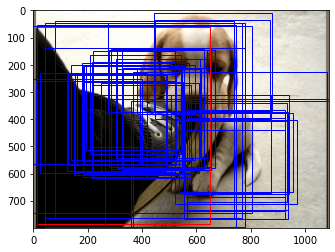

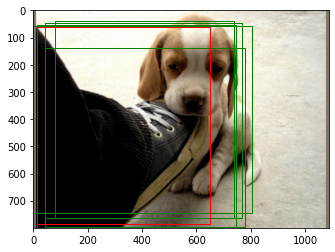

In [73]:
plot_gt_boxes(backbone.to(device), rpn.to(device), useours=True)

### 2) Plot Graphs

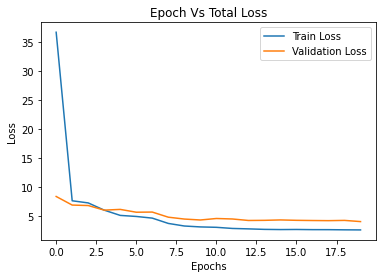

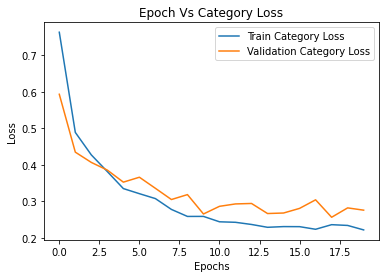

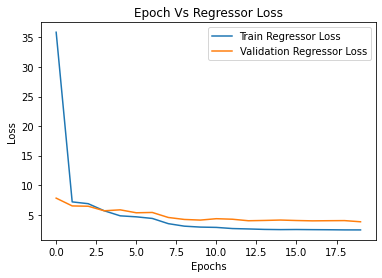

In [105]:
plot_graphs()

### 3) Top 20 Predictions

In [108]:
device = 'cuda'
model = BoxHead.load_from_checkpoint(checkpoint_path='/content/drive/My Drive/680/hw4B/model_seedless/epoch=18_Model.ckpt')
model =  model.to(device)
backbone, rpn = pretrained_models_680(pretrained_path, useours=False)
# backbone, rpn = pretrained_models_680(checkpoint_ours, useours=True)
useours=False

In [109]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=dataset.collate_fn)

for iter, batch in enumerate(test_loader, 0):
  images, labels, boxes, masks, indexes = batch
  break
images = images.to(device)

backout = backbone(images.float())
if useours:
  logits, reg_bbox = rpn.forward(images.float())
  _ , proposals= rpn.postprocessImg(logits,reg_bbox, 0.5, 2000, 1000)
  proposals = [proposals]

else:
  im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
  rpnout = rpn(im_lis, backout)
  keep_topK = 200
  proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]  

fpn_feat_list= list(backout.values())

feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list,proposals)
class_logits, box_pred= model.forward(feature_vectors.to(device), eval=True)
fin_conf, fin_postbox, fin_lab = model.postprocess_detections(class_logits, box_pred, proposals, conf_thresh=0.5, keep_num_preNMS=2000, keep_num_postNMS=200)

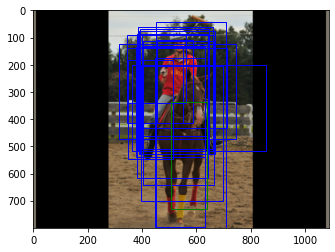

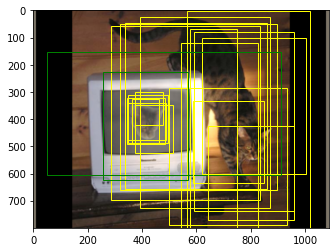

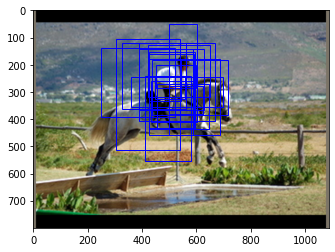

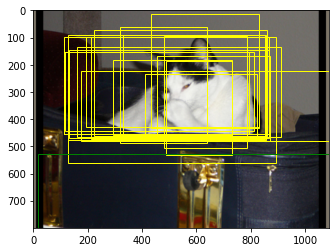

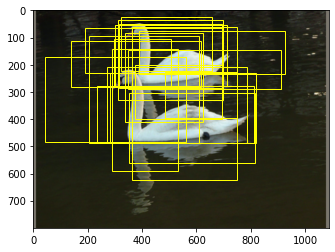

In [110]:
plot_topK(5, backbone.to(device), rpn.to(device))

### 4) mAP Score and AP

In [ ]:
total_matches, total_scores, total_trues = mean_average_precision(model, rpn, backbone)
AP=0
ap_list = []
cnt =0
for c in range(3):
  if (len(total_matches[c])>0):
    area, precision_mat, recall_mat = average_precision(total_matches[c],total_scores[c],total_trues[c])
    AP  += area
    ap_list.append(area)
    plt.figure()
    plt.plot(recall_mat, precision_mat)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Class "+str(c))
    plt.show()
    print(area)
    cnt+=1;
  if cnt>0:
    map=AP/cnt
print("Mean Average Precision is : ", map)
print("Average Precision is : ", ap_list)

### 5) Before and After Post Processing

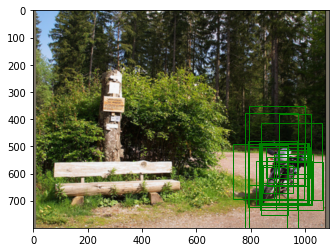

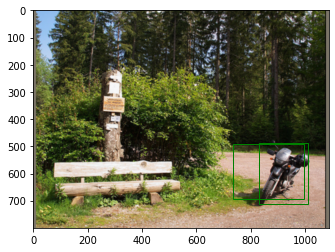

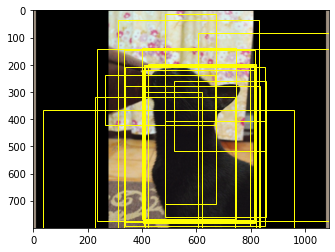

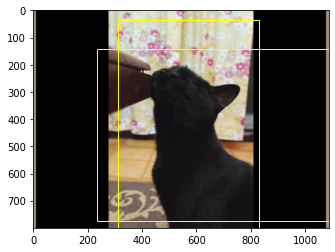

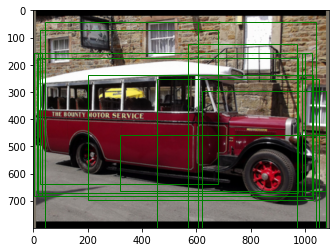

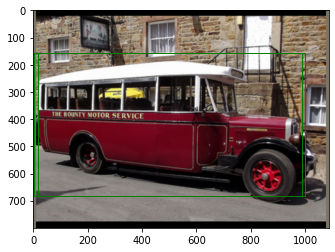

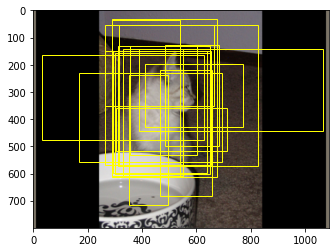

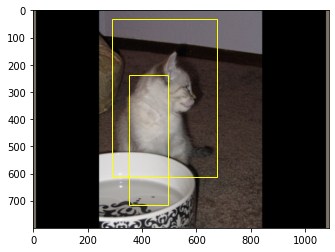

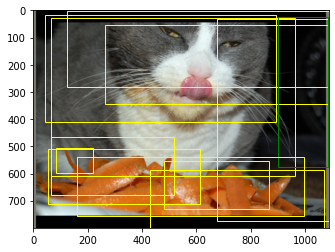

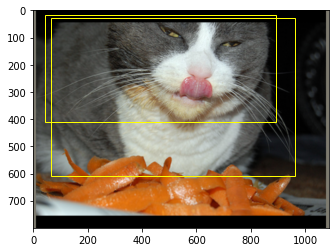

In [ ]:
plot_topKvsnms(ktimes=5)

### Evaluation Test

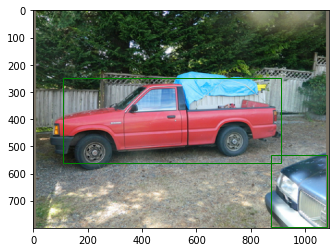

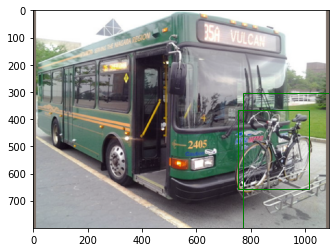

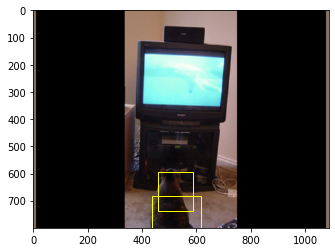

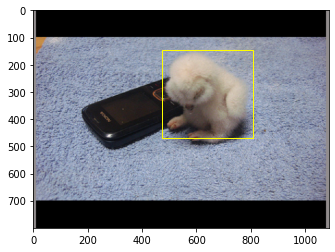

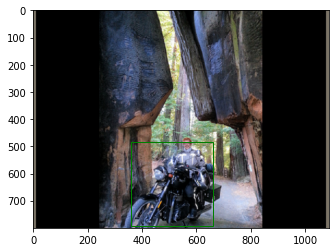

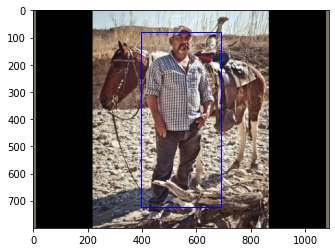

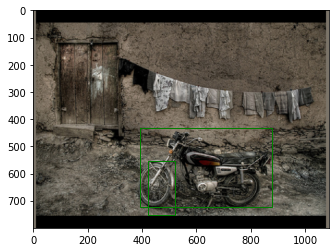

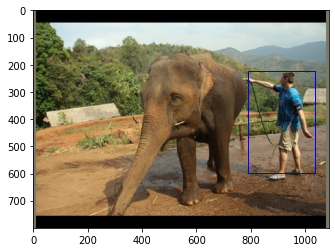

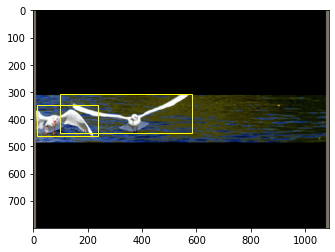

In [ ]:
# Put the path were the given hold_out_images.npz file is save and load the images
hold_images_path='/content/drive/My Drive/680/hw4/HW4_PartB_Code_Template/hold_out_images.npz'
test_images=np.load(hold_images_path,allow_pickle=True)['input_images']
backbone, rpn = pretrained_models_680(pretrained_path, useours=False)

# Load your model here. If you use different parameters for the initialization you can change the following code
# accordingly
device = 'cuda'
model = BoxHead.load_from_checkpoint(checkpoint_path='/content/drive/My Drive/680/hw4B/model_attached/epoch=22_Model.ckpt')
model =  model.to(device)
keep_topK=200
backbone = backbone.to(device)
rpn = rpn.to(device)
cpu_boxes = []
cpu_scores = []
cpu_labels = []

for i, numpy_image in enumerate(test_images, 0):
    images = torch.from_numpy(numpy_image).to(device)
    with torch.no_grad():
        # Take the features from the backbone
        backout = backbone(images)

        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        feature_vectors=model.MultiScaleRoiAlign(fpn_feat_list,proposals)

        class_logits,box_pred=model.forward(feature_vectors.detach(), eval=True)

        # Do whaterver post processing you find performs best
        scores, boxes, labels = model.postprocess_detections(class_logits, box_pred, proposals, conf_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=3)        

        if (i>30 and i<40) and boxes is not 0:
          img_squeeze=images[0,:,:,:].to('cpu').numpy()
          x_min = img_squeeze.min(axis=(1, 2), keepdims=True)
          x_max = img_squeeze.max(axis=(1, 2), keepdims=True)
          img_squeeze = (img_squeeze - x_min)/(x_max-x_min)
          fig,ax=plt.subplots(1,1)
          ax.imshow(np.transpose(img_squeeze, axes=(1,2,0)))
          c=['none', 'green', 'blue','yellow']
          for no in range(len(boxes)):
              box=boxes[no].detach().cpu().numpy()
              lab= labels[no].item()
              rect=Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color=c[lab])
              ax.add_patch(rect)
          plt.show()   

        if boxes is 0:
            cpu_boxes.append(None)
            cpu_scores.append(None)
            cpu_labels.append(None)
        else:
            cpu_boxes.append(boxes.to('cpu').detach().numpy())
            cpu_scores.append(scores[:,0].to('cpu').detach().numpy())
            cpu_labels.append(labels[:,0,0].to('cpu').detach().numpy())

np.savez('predictions.npz', predictions={'boxes': cpu_boxes, 'scores': cpu_scores,'labels': cpu_labels})